# Decision Trees and Ensemble Learning

## Import Libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

## Load Data

In [2]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [5]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

## Preparing the datase

In [6]:
# fill missing values with 0
df.fillna(0, inplace=True)

In [7]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [8]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% usind train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# Split the full train into 60% train and 20% validation
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)  # 0.25 * 80% = 20%

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# Verify the sizes
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 5822
Validation size: 1941
Test size: 1941


# Q1

In [9]:
#Use DictVectorizer(sparse=True) to turn the dataframes into matrices
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')


In [10]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [11]:
# Let's train a decision tree regressor to predict the median_house_value variable. Train a model with max_depth=1.
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [12]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



# Q2

In [13]:
#Train a random forest model with these parameters:

#n_estimators=10
#random_state=1
#n_jobs=-1 (optional - to make training faster)

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [14]:
# Calcualate RMSE for the validation dataset. 

y_pred = rf.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print('RMSE:', rmse)

RMSE: 0.45707126026197337


# Q3

In [15]:
#Now let's experiment with the n_estimators parameter

#Try different values of this parameter from 10 to 200 with step 10.
#Set random_state to 1.
#Evaluate the model on the validation dataset.
#After which value of n_estimators does RMSE stop improving?

n_estimators_list = list(range(10, 201, 10))
rmse_list = []  
for n_estimators in tqdm(n_estimators_list):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_list.append((n_estimators, rmse))

  0%|          | 0/20 [00:00<?, ?it/s]

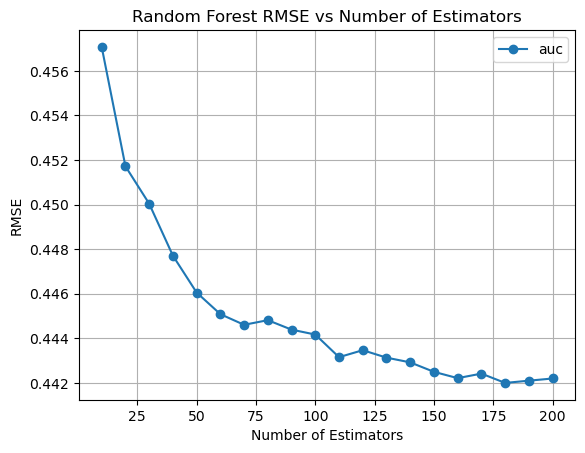

In [16]:
df_scores = pd.DataFrame(rmse_list, columns=['n_estimators', 'auc'])
df_scores.plot(x='n_estimators', y='auc', kind='line', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('RMSE')
plt.title('Random Forest RMSE vs Number of Estimators')
plt.grid(True)
plt.show()

# Q4

In [17]:
rmse_list = []

for d in tqdm([10, 15, 20, 25]):
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        rmse_list.append((n_estimators, rmse))

        rmse_list.append((d, n, rmse))

  0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(rmse_list, columns=columns)

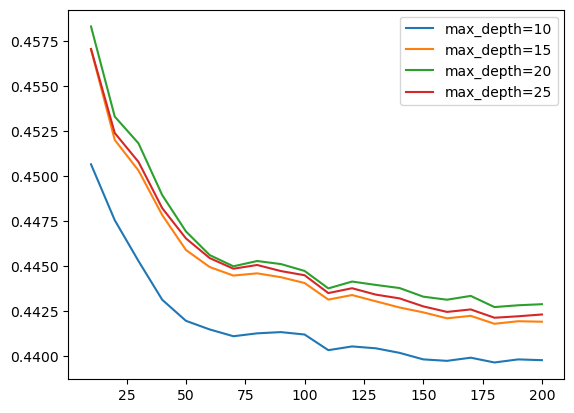

In [19]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()
plt.show()

# Q5

In [20]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

#Get the feature importance information from this model
importances = rf.feature_importances_
importances

array([1.14536287e-02, 3.96650944e-04, 3.11283259e-04, 3.28170182e-03,
       3.69466267e-04, 3.01551010e-04, 1.60423301e-02, 3.16452511e-03,
       2.33145848e-03, 1.62794233e-03, 4.85137573e-04, 4.93652614e-04,
       5.64584351e-04, 9.59176087e-01])

In [21]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_


# Sort the dataframe by importance in descending order
df_importances = df_importances.sort_values(by='importance', ascending=False)

df_importances

,feature,importance
13,vehicle_weight,0.959176
6,horsepower,0.016042
0,acceleration,0.011454
3,engine_displacement,0.003282
7,model_year,0.003165
8,num_cylinders,0.002331
9,num_doors,0.001628
12,origin=USA,0.000565
11,origin=Europe,0.000494
10,origin=Asia,0.000485


# Q6

In [29]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [30]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [31]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [43]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    evals=watchlist)

In [44]:
s = output.stdout

In [45]:
s

'[0]\ttrain-rmse:2.28944\tval-rmse:2.34561\n[1]\ttrain-rmse:2.07396\tval-rmse:2.12434\n[2]\ttrain-rmse:1.88066\tval-rmse:1.92597\n[3]\ttrain-rmse:1.70730\tval-rmse:1.74987\n[4]\ttrain-rmse:1.55163\tval-rmse:1.59059\n[5]\ttrain-rmse:1.41247\tval-rmse:1.44988\n[6]\ttrain-rmse:1.28796\tval-rmse:1.32329\n[7]\ttrain-rmse:1.17660\tval-rmse:1.20930\n[8]\ttrain-rmse:1.07736\tval-rmse:1.10830\n[9]\ttrain-rmse:0.98883\tval-rmse:1.02009\n[10]\ttrain-rmse:0.91008\tval-rmse:0.94062\n[11]\ttrain-rmse:0.84030\tval-rmse:0.87100\n[12]\ttrain-rmse:0.77874\tval-rmse:0.80916\n[13]\ttrain-rmse:0.72417\tval-rmse:0.75465\n[14]\ttrain-rmse:0.67626\tval-rmse:0.70780\n[15]\ttrain-rmse:0.63402\tval-rmse:0.66672\n[16]\ttrain-rmse:0.59690\tval-rmse:0.63062\n[17]\ttrain-rmse:0.56447\tval-rmse:0.60016\n[18]\ttrain-rmse:0.53619\tval-rmse:0.57383\n[19]\ttrain-rmse:0.51138\tval-rmse:0.55044\n[20]\ttrain-rmse:0.48983\tval-rmse:0.53064\n[21]\ttrain-rmse:0.47135\tval-rmse:0.51451\n[22]\ttrain-rmse:0.45501\tval-rmse:0.4999

In [46]:
scores['eta=0.1'] = parse_xgb_output(output)

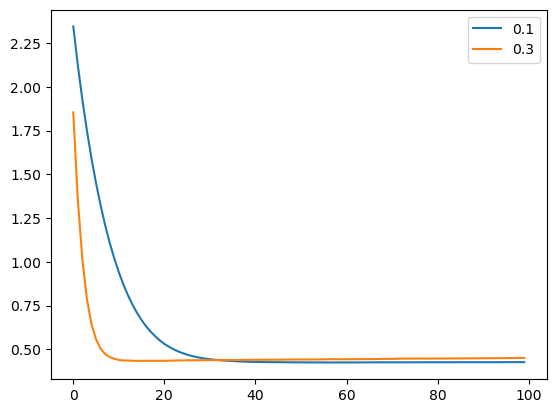

In [47]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()